In [1]:
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
# from utils.plot_utils import init_darkmode

# init_darkmode()

## General framework for mappings, iterating mappings and visualize iteration results

A `map`, `function` or `rule` in general has a `state` defined by a set of `variables` $V$ and some properties defined by a set of `parameters` $P$. A parameter is an estimate of a given property of the system.

In [2]:
def iterate(map: Callable, P: dict, V: dict=None, n=0) -> dict:

    if not V or n<1:
        return {}    
    else:
        # init trajectories with start value at t=0
        trajectories = { key: [value] for key, value in V.items()}
        for _ in range(n-1):
            V_hat = map(P, V)
            for key, value in V_hat.items():
                trajectories[key].append(value)
            V = V_hat
        return trajectories


def plot_iterations(P: dict, V: dict, ax=None, figsize=(16,4), labels=False):

    if ax:
        result = ax
    else:
        result = None
        _, ax = plt.subplots(1, 1, figsize=figsize)

    if V:
        ps = '['+ (', '.join(f'{key}:{value:.4g}' for key, value in P.items()) if P else 'NA') + ']'
        v0s = '['+ (', '.join(f'{key}:{value[0]:.4g}' for key, value in V.items()) if V else 'NA') + ']'
        n_iter = max(0, max(len(value) for value in V.values()))

        ylabels=[]
        x = range(1, n_iter+1)
        for key, y in V.items():
            ax.plot(x, y, marker='.', lw=1,label=f'${key} \, | \, p={ps}, \, V_0={v0s}$')
            ylabels.append(f'${key}_t$')
        ax.set_xlabel(f'$time$ $→$')
        ax.set_ylabel(' / '.join(ylabels))
        if n_iter < 40:
            ax.set_xticks(x)

        plt.legend(loc="upper left")
        if result is None:
            plt.tight_layout()
    return result


def plot_cobweb(map, P, V, ax=None):
    """
    A cobweb plot, or Verhulst diagram is a visual tool used in the dynamical systems 
    field of mathematics to investigate the qualitative behaviour of one-dimensional 
    iterated functions, such as the logistic map. 
    
    Using a cobweb plot, it is possible to infer the long term status of an initial 
    condition under repeated application of a map.
    """

    if not ax:
            _, ax = plt.subplots(1, 1, figsize=(4, 4))
            result = None
    else:
        result = ax

    # check map is 1D, has one variable only
    # and get bounds of the maps variable
    if V and len(V.keys())==1:

        key = list(V.keys())[0]
        v = V[key]

        v_min = min(0.0, min(v))
        v_max = max(1.0, max(v))

        # plot mapping
        V_map = V.copy()
        V_map[key] = np.linspace(v_min, v_max)

        v_map = V_map[key]
        v_map_hat = map(P, V_map)[key]
        ax.plot(v_map, v_map_hat, c='b', lw=2)
        ax.plot(v_map, v_map, c='b', lw=1)

        n = len(V[key])
        if n==1:
            ax.plot([v[0]], [v[0]], 'oy', ms=5)
            # ax.set_title(f'$r={r:.1f}, \, x_0={t[0]:.2g}$')
        else:
            # Recursively apply y=f(x) and plot two lines:
            # (x, x) -> (x, y)
            # (x, y) -> (y, y)
            for i in range(n-2):
                ax.plot([v[i], v[i]], [v[i], v[i+1]], c='y', lw=1)
                ax.plot([v[i]], [v[i+1]], 'oy', ms=5, alpha=(i+1)/n)
                ax.plot([v[i], v[i+1]], [v[i+1], v[i+1]], c='y', lw=1)
            ax.plot([v[-2], v[-2]], [v[-2], v[-1]], c='y', lw=1)
            ax.plot([v[0]], [v[0]], 'or', ms=5)
            c = 'g' if n>1 else 'y'
            ax.plot([v[-2]], [v[-1]], color=c, marker='o', ms=5)
            # ax.set_title(f'$r={r:.6g}, \, x_0={v[0]:.2g}, \, n={n}$')
            ax.set_ylabel('$x_{t+1}$')
    ax.set_xlabel('$x_{t}$')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('Cobweb')

    return result 

# Logistic map

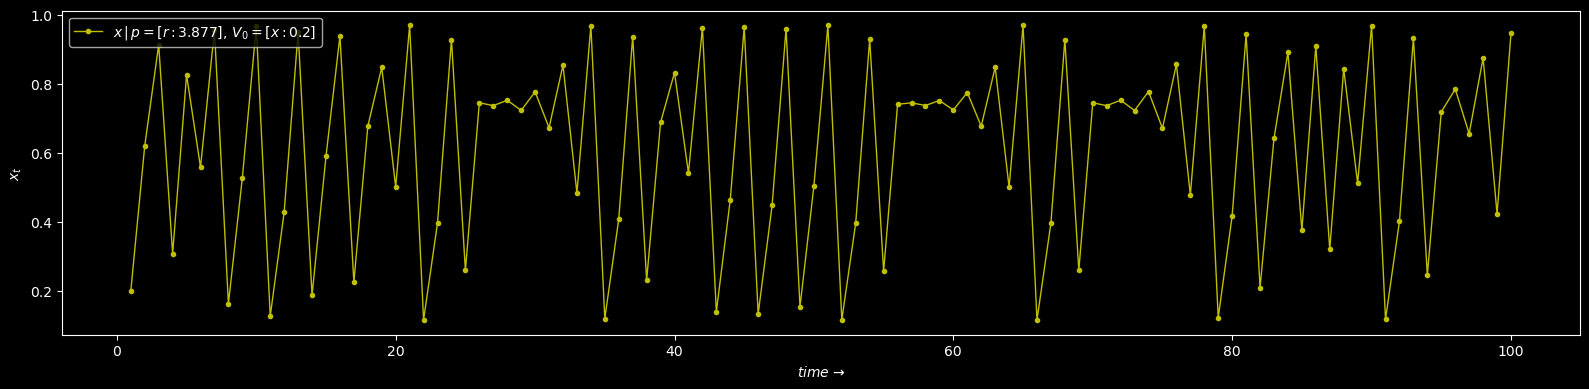

In [3]:
def logistic_map(P: dict, V: dict) -> dict:
    """The implementation of a relative population system with:
    -  parameters `P: ['r'] and,
    -  variables `V: ['x']`,
    that maps to the output variable v_hat['x']`
    """
    r = P['r']  # reproduction rate
    x = V['x']  # relative population size

    x_hat = r * x * (1 - x)

    return {'x': x_hat}


P={'r': 3.8768}

x0 = 0.2
V={'x':x0}

V_hat = iterate(logistic_map, P, V, n=100)
plot_iterations(P, V_hat)

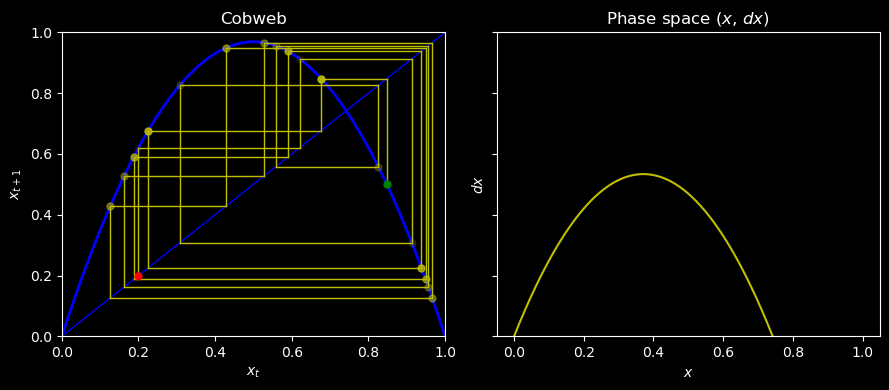

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

V_hat = iterate(logistic_map, P, V, n=20)

plot_cobweb(logistic_map, P, V_hat, ax=ax1)


V_map = {'x': np.linspace(0.0,1.0,1000)}
v_map = V_map['x']
V_map_hat = logistic_map(P, V_map) 
v_map_dx = V_map_hat['x'] - v_map

ax2.plot(v_map, v_map_dx)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$dx$')
ax2.set_title('Phase space ($x$, $dx$)')
plt.tight_layout()

## Predator Prey model

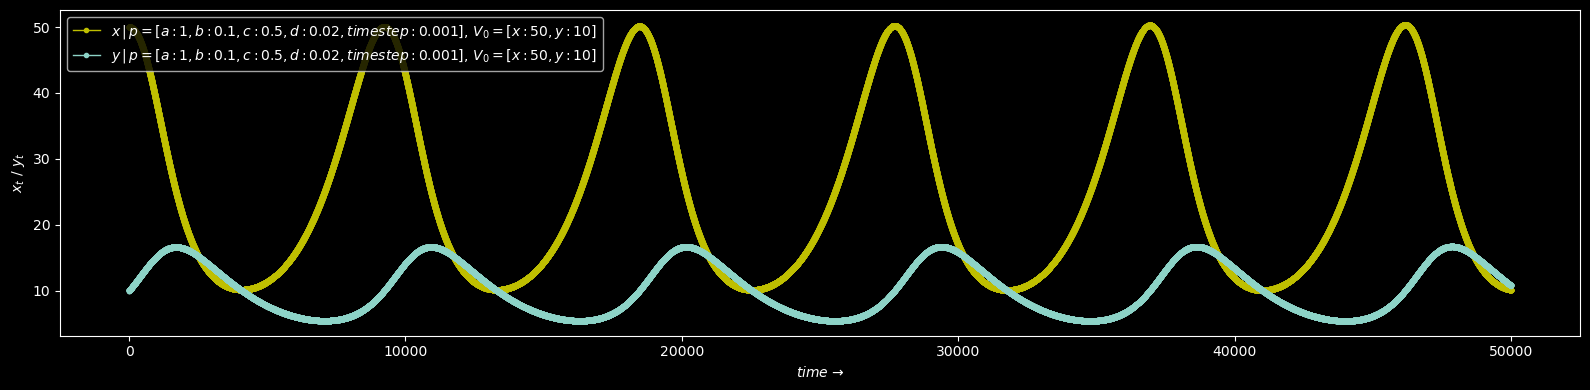

In [5]:
def pred_prey_map(P: dict, V: dict) -> dict:
    """
    The implementation of a predator prey system with:
    -  parameters `P: ['a', 'b', 'c', 'd', 'timestep'] and,
    -  variables `V: ['x', 'y']`,
    that maps to the output variable v_hat['x', 'y']`.
    """
    
    # Parameter setup
    a = P['a']
    b = P['b']
    c = P['c']
    d = P['d']
    timestep = P['timestep']
    
    # Map the states into local variable names
    x = V['x']
    y = V['y']

    # evaluate the current differentials
    x_hat = x + (x * (a - b * y)) * timestep
    y_hat = y + (-y * (c - d * x)) * timestep

    return {'x': x_hat, 'y': y_hat}


# initial conditions for the rabbit (x) and fox (y)
x0 = 50 # rabbits
y0 = 10 # foxes
V = {'x': x0, 'y':y0}

# definition of lotka-volterra parameters
a = 1     # birth rate of rabbits
b = 0.1   # death rate of rabbits due to predation
c = 0.5   # natural death rate of foxes
d = 0.02  # factor that describes how many eaten rabbits give birth to a new fox

timestep = 0.001
n = 50

P = {'a':a, 'b':b, 'c':c ,'d':d, 'timestep':timestep}


V_hat = iterate(pred_prey_map, P, V, n=int(n/timestep))

plot_iterations(P, V_hat)


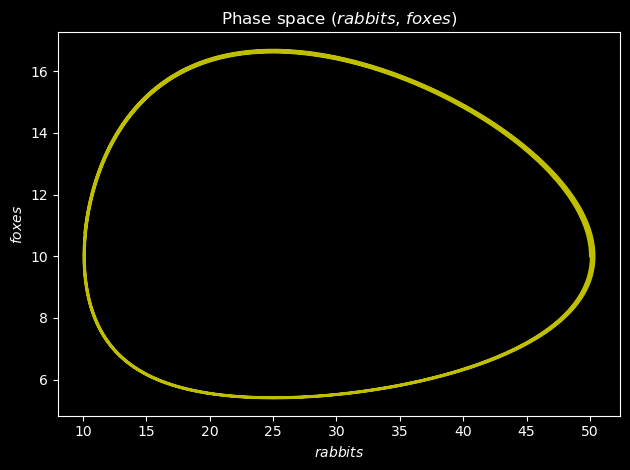

In [7]:
plt.plot(V_hat['x'],V_hat['y'])
plt.xlabel('$rabbits$')
plt.ylabel('$foxes$')
plt.title('Phase space ($rabbits$, $foxes$)')
plt.tight_layout()